#### Datachallenge 2
# Investigating a Drop in User Engagement

We have seen a recent drop in user engagement on the Yammer platform, shown in the graph [below](#Data-visualization), which shows weekly unique logins. We want to investigate what happened, using the historical data about user engagement with the platform.

#### Some first theories as to what could have happened.

1. The drop starts in August, which is a big vacation month in parts of the world (in the Mediterranean for example, entire companies may be closed for a couple weeks or the entire month), so maybe vacation season causes the observed drop?
    - This could be examined by looking into any geographic patterns in user engagement.
2. The drop could be caused by one (or few) big clients dropping out. Looking into engagement evolution for different companies could shed a light on that.
3. Could there be technical issues on the side of Yammer that make it hard for users to connect? This won't be clear from the data we currently have (and should be considered unlikely, since in the course of a month we should expect feedback from users alerting us to such a widespread issue), but would be worth a quick check.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

We read in the three data files, and take a first look at the data.

In [2]:
users = pd.read_csv('yammer_users.csv', low_memory=False)
events = pd.read_csv('yammer_events.csv', low_memory=False)
emails = pd.read_csv('yammer_emails.csv', low_memory=False)

In [3]:
users.head(2)

,user_id,created_at,company_id,language,activated_at,state
0,0.0,2013-01-01 20:59:39,5737.0,english,2013-01-01 21:01:07,active
1,1.0,2013-01-01 13:07:46,28.0,english,NaN,pending


In [4]:
events.head(2)

,user_id,occurred_at,event_type,event_name,location,device,user_type
0,10522.0,2014-05-02 11:02:39,engagement,login,Japan,dell inspiron notebook,3.0
1,10522.0,2014-05-02 11:02:53,engagement,home_page,Japan,dell inspiron notebook,3.0


In [5]:
emails.head(2)

,user_id,occurred_at,action,user_type
0,0.0,2014-05-06 09:30:00,sent_weekly_digest,1.0
1,0.0,2014-05-13 09:30:00,sent_weekly_digest,1.0


Let's look into active vs inactive users.

In [6]:
users[users.state=='pending'].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9685 entries, 1 to 19065
Data columns (total 6 columns):
user_id         9685 non-null float64
created_at      9685 non-null object
company_id      9685 non-null float64
language        9685 non-null object
activated_at    0 non-null object
state           9685 non-null object
dtypes: float64(2), object(4)
memory usage: 529.6+ KB


Roughly half of the users are 'pending', meaning they haven't been activated yet. Short analysis in SQL confirms that pending users have no engagement (other than actions during sign-up process; event table has pending users only when event_type='signup_flow', and email table has no pending users). I'm assuming the active users are then who we need to focus on for our analysis.

In order to create plots, we merge tables and create datetime columns.

In [10]:
events_users = events.merge(users,how='left',on='user_id')
events_users.loc[:,'occurred_at'] = pd.to_datetime(events_users.occurred_at)
events_users.loc[:,'created_at'] = pd.to_datetime(events_users.created_at)
events_users.loc[:,'activated_at'] = pd.to_datetime(events_users.activated_at)

In [16]:
events_users.head()

,user_id,occurred_at,event_type,event_name,location,device,user_type,created_at,company_id,language,activated_at,state
0,10522.0,2014-05-02 11:02:39,engagement,login,Japan,dell inspiron notebook,3.0,2014-04-04 16:48:03,1147.0,japanese,2014-04-04 16:49:36,active
1,10522.0,2014-05-02 11:02:53,engagement,home_page,Japan,dell inspiron notebook,3.0,2014-04-04 16:48:03,1147.0,japanese,2014-04-04 16:49:36,active
2,10522.0,2014-05-02 11:03:28,engagement,like_message,Japan,dell inspiron notebook,3.0,2014-04-04 16:48:03,1147.0,japanese,2014-04-04 16:49:36,active
3,10522.0,2014-05-02 11:04:09,engagement,view_inbox,Japan,dell inspiron notebook,3.0,2014-04-04 16:48:03,1147.0,japanese,2014-04-04 16:49:36,active
4,10522.0,2014-05-02 11:03:16,engagement,search_run,Japan,dell inspiron notebook,3.0,2014-04-04 16:48:03,1147.0,japanese,2014-04-04 16:49:36,active


In [17]:
events_users.set_index?

Signature:
events_users.set_index(
    ['keys', 'drop=True', 'append=False', 'inplace=False', 'verify_integrity=False'],
)
Docstring:
Set the DataFrame index (row labels) using one or more existing
columns. By default yields a new object.

Parameters
----------
keys : column label or list of column labels / arrays
drop : boolean, default True
    Delete columns to be used as the new index
append : boolean, default False
    Whether to append columns to existing index
inplace : boolean, default False
    Modify the DataFrame in place (do not create a new object)
verify_integrity : boolean, default False
    Check the new index for duplicates. Otherwise defer the check until
    necessary. Setting to False will improve the performance of this
    method

Examples
--------
>>> df = pd.DataFrame({'month': [1, 4, 7, 10],
...                    'year': [2012, 2014, 2013, 2014],
...                    'sale':[55, 40, 84, 31]})
   month  sale  year
0  1      55    2012
1  4      40    2014
2  

The below table will have the occurred_at column as its index, this makes some plotting operations and labeling easier.

In [18]:
ev_us_dt = events_users.set_index('occurred_at')

In [19]:
ev_us_dt.head()

,user_id,event_type,event_name,location,device,user_type,created_at,company_id,language,activated_at,state
occurred_at,,,,,,,,,,,
2014-05-02 11:02:39,10522.0,engagement,login,Japan,dell inspiron notebook,3.0,2014-04-04 16:48:03,1147.0,japanese,2014-04-04 16:49:36,active
2014-05-02 11:02:53,10522.0,engagement,home_page,Japan,dell inspiron notebook,3.0,2014-04-04 16:48:03,1147.0,japanese,2014-04-04 16:49:36,active
2014-05-02 11:03:28,10522.0,engagement,like_message,Japan,dell inspiron notebook,3.0,2014-04-04 16:48:03,1147.0,japanese,2014-04-04 16:49:36,active
2014-05-02 11:04:09,10522.0,engagement,view_inbox,Japan,dell inspiron notebook,3.0,2014-04-04 16:48:03,1147.0,japanese,2014-04-04 16:49:36,active
2014-05-02 11:03:16,10522.0,engagement,search_run,Japan,dell inspiron notebook,3.0,2014-04-04 16:48:03,1147.0,japanese,2014-04-04 16:49:36,active


#### Data visualization

For a start, this is the plot we are starting out from in the description: We filter by user engagement, resample weekly and plot the unique counts of users. In addition to users, we also plot unique company counts, and we find the same general trend.

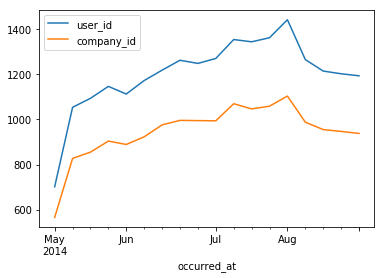

In [56]:
_= ev_us_dt[(ev_us_dt.event_type=='engagement')].loc[:,['user_id','company_id']].resample('W').nunique().plot()

## Play around with this

In [69]:
ev_us_dt[(ev_us_dt.event_type=='engagement')].loc[:,['user_id','company_id']].resample('W').nunique().head()

,user_id,company_id
occurred_at,,
2014-05-04,701,565
2014-05-11,1054,827
2014-05-18,1094,855
2014-05-25,1147,904
2014-06-01,1113,889


In [25]:
ev_us_dt[ev_us_dt.event_type=='engagement'].head()

,user_id,event_type,event_name,location,device,user_type,created_at,company_id,language,activated_at,state
occurred_at,,,,,,,,,,,
2014-05-02 11:02:39,10522.0,engagement,login,Japan,dell inspiron notebook,3.0,2014-04-04 16:48:03,1147.0,japanese,2014-04-04 16:49:36,active
2014-05-02 11:02:53,10522.0,engagement,home_page,Japan,dell inspiron notebook,3.0,2014-04-04 16:48:03,1147.0,japanese,2014-04-04 16:49:36,active
2014-05-02 11:03:28,10522.0,engagement,like_message,Japan,dell inspiron notebook,3.0,2014-04-04 16:48:03,1147.0,japanese,2014-04-04 16:49:36,active
2014-05-02 11:04:09,10522.0,engagement,view_inbox,Japan,dell inspiron notebook,3.0,2014-04-04 16:48:03,1147.0,japanese,2014-04-04 16:49:36,active
2014-05-02 11:03:16,10522.0,engagement,search_run,Japan,dell inspiron notebook,3.0,2014-04-04 16:48:03,1147.0,japanese,2014-04-04 16:49:36,active


In [37]:
foo = ev_us_dt[(ev_us_dt.event_type=='engagement')].loc[:,['user_id','company_id']]
foo.head()

,user_id,company_id
occurred_at,,
2014-05-02 11:02:39,10522.0,1147.0
2014-05-02 11:02:53,10522.0,1147.0
2014-05-02 11:03:28,10522.0,1147.0
2014-05-02 11:04:09,10522.0,1147.0
2014-05-02 11:03:16,10522.0,1147.0


In [54]:
foo2 = foo.resample('W')
foo.head()

,user_id,company_id
occurred_at,,
2014-05-02 11:02:39,10522.0,1147.0
2014-05-02 11:02:53,10522.0,1147.0
2014-05-02 11:03:28,10522.0,1147.0
2014-05-02 11:04:09,10522.0,1147.0
2014-05-02 11:03:16,10522.0,1147.0


In [55]:
foo2.nunique()

,user_id,company_id
occurred_at,,
2014-05-04,701,565
2014-05-11,1054,827
2014-05-18,1094,855
2014-05-25,1147,904
2014-06-01,1113,889
2014-06-08,1173,923
2014-06-15,1219,976
2014-06-22,1263,996
2014-06-29,1249,995


To see whether there is some regional trend (that might support our vacation hypothesis), we plot login numbers for some countries with highest user numbers, grouped by continent to simplify interpretation.

In [10]:
americas = ['Canada', 'Mexico', 'Brazil']#'United States', 
europe = ['Germany', 'France', 'United Kingdom', 'Italy']
asiaoceania = ['Japan','India','China','Russia','Australia']

In [11]:
# this from https://matplotlib.org/gallery/text_labels_and_annotations/date.html
# to format axis labels
import matplotlib.dates as mdates 

months = mdates.MonthLocator()  # every month
monthsFmt = mdates.DateFormatter('%m-%Y')


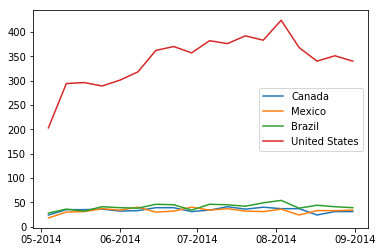

In [12]:
fig,ax1 = plt.subplots(1,1)

for ctry in americas+['United States']:    
    plotseries = ev_us_dt[(ev_us_dt.event_name=='login') & (ev_us_dt.location==ctry)].user_id.resample('W').nunique()
    _ = ax1.plot(plotseries, label=ctry)
ax1.legend()
ax1.xaxis.set_major_locator(months)
ax1.xaxis.set_major_formatter(monthsFmt)

The trend is clearly visible for users in the United States. The US user numbers flatten out everything else however, so we'll remove the US from this plot to get a better idea of the other countries.

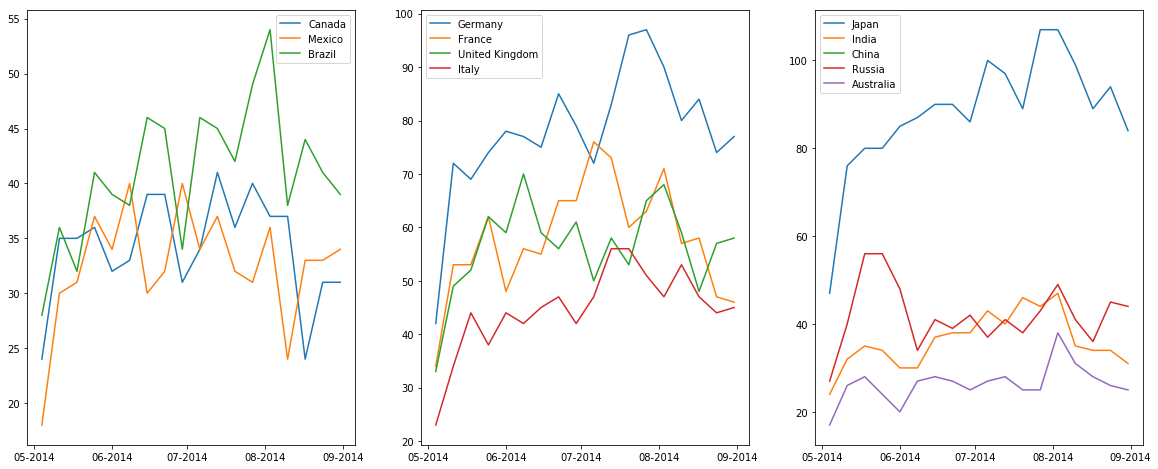

In [13]:
fig,[ax1,ax2,ax3] = plt.subplots(1,3,figsize=(20,8))

for ctry in americas:
    plotseries = ev_us_dt[(ev_us_dt.event_name=='login') & (ev_us_dt.location==ctry)].user_id.resample('W').nunique()
    _ = ax1.plot(plotseries, label=ctry)
ax1.legend()
ax1.xaxis.set_major_locator(months)
ax1.xaxis.set_major_formatter(monthsFmt) 

for ctry in europe:
    plotseries = ev_us_dt[(ev_us_dt.event_name=='login') & (ev_us_dt.location==ctry)].user_id.resample('W').nunique()
    _ = ax2.plot(plotseries, label=ctry)
ax2.legend()
ax2.xaxis.set_major_locator(months)
ax2.xaxis.set_major_formatter(monthsFmt)

for ctry in asiaoceania:
    plotseries = ev_us_dt[(ev_us_dt.event_name=='login') & (ev_us_dt.location==ctry)].user_id.resample('W').nunique()
    _ = ax3.plot(plotseries, label=ctry)
ax3.legend()
ax3.xaxis.set_major_locator(months)
_ = ax3.xaxis.set_major_formatter(monthsFmt)


We find that across continents, some downward trend in engagement can be observed in August. The countries with seemingly the least effect are Mexico and Russia (both show a sharp tip in early August but then engagement appears to rembound in the weeks after). The overall user numbers for these countries are low however, so this may not be a significant observation.

The overall trend is however an indicator that we are not dealing with a local phenomenon (like vacation season in some part of the world, or one or few individual companies quitting the service).

Below, we look at different types of user engagement (not just login), to see how they are related (we expect to  see a similar trend in other categories, since login is the first step toward other actions).

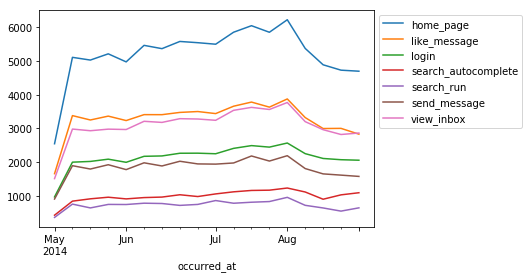

In [21]:
event_dummies = pd.get_dummies(ev_us_dt[(ev_us_dt.state=='active') & (ev_us_dt.event_type=='engagement')].event_name)
event_dummies = event_dummies.resample('W').sum()
todrop = [col for col in event_dummies.columns if 'search_click_result' in col]
event_dummies = event_dummies.drop(todrop,axis=1)

event_dummies.plot()
_ = plt.legend(bbox_to_anchor=(1,1))

As expected, the trend persists across these categories.

#### Engagement with emails

Let's now look at how user engagement with emails is evolving over time.

We first merge the users and emails dataframes, and make some plots. We also introduce a column 'occurred_after', counting the days since we started collecting data that a certain action is taken.

In [17]:
emails_users = emails.merge(users,how='left',on='user_id')
emails_users.loc[:,'occurred_after'] = pd.to_datetime(emails_users.occurred_at) - pd.to_datetime(emails_users.occurred_at.min())
emails_users.at[:,'occurred_after'] = emails_users.occurred_after.dt.days
emails_users.loc[:,'occurred_at']= pd.to_datetime(emails_users.occurred_at)
emailus_dt = emails_users.set_index('occurred_at')

We plot different types of actions related to emails over time.

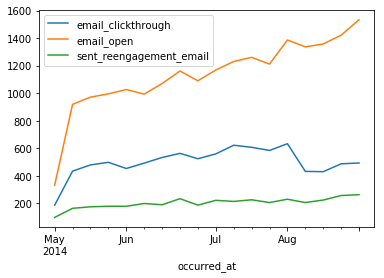

In [26]:
toplot = pd.get_dummies(emailus_dt[emailus_dt.state=='active'].action)
fig,ax = plt.subplots(1,1)
for val in toplot.columns[:-1]:
    toplot.loc[:,val].resample('W').sum().plot(kind='line')
_ = ax.legend(toplot.columns.values)

We observe the dip in clickthrough, a little less in opening emails. If we plot counts of actions regarding email, we observe clear weekly seasonality, with a slight downward trend in clickthroughs:

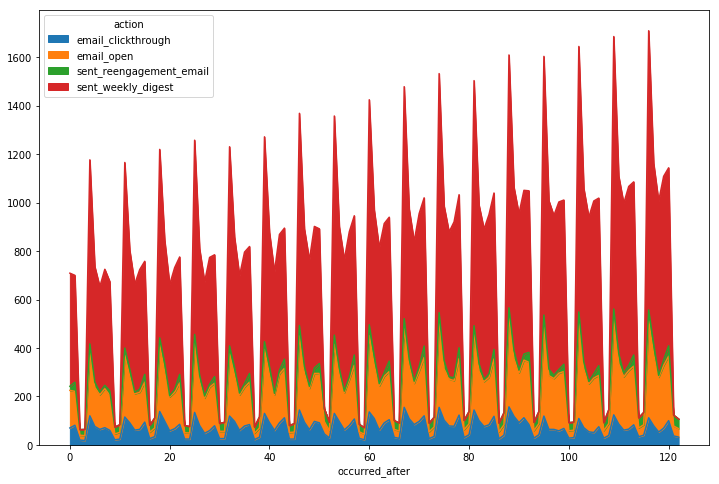

In [19]:
fig, ax = plt.subplots(1,1,figsize=(12,8))
ax =emails_users.action.groupby(emails_users.occurred_after).value_counts().unstack('action').plot(kind='area',stacked=True, ax=ax)

### Conclusion

A brief exploration didn't confirm the vacation hypothesis, but further analysis would be needed to confirm whether this is the cause of the drop or not. With more time, my next step would be to also look into the effect of individual companies to see how engagement varies on that more granular level, and whether this exposes any significant trends.